In [1]:
import torch
from torch.utils.data.dataset import Dataset
from PIL import Image
from os import path
from torchvision import transforms
import numpy as np

# First test implementation

## Costruction of dataset

- `all_labels.txt`: All image's labels of all entire dataset
- `classes.txt`: classes
- `test.txt`: test dataset
- `test.txt`: train dataset 

In [2]:
class TrashbeanDataset(Dataset):
    def __init__(self, base_path, txt_list, transform=None):
        IMG_CHANNEL = 3

        self.txt_list = txt_list ## utile per la normalizzazione

        self.base_path = base_path
        self.images = np.loadtxt(txt_list, dtype=str, delimiter=',')
        self.mean = np.zeros(IMG_CHANNEL)
        self.dev_std = np.zeros(IMG_CHANNEL)

        self.transform = transform

    def __getitem__(self, index):
        f,c = self.images[index] # recuperiamo il path dell'immagine di indice index e la relativa etichetta
        im = Image.open(path.join(self.base_path, f))   ## load img with PIL

        if self.transform is not None:          ## toTensor, resize, normalize etc...
            im = self.transform(im)

        label = int(c) # converto l'etichetta in intero

        return {'image': im, 'label': label}    # return dictionary --> immagine : etichetta

    def _bef_normalize(self):
        for sample in self:
            self.mean += sample['image'].sum(1).sum(1).numpy() ## accumulo somma dei pixel canale per canale

        self.mean = self.mean / ( len(self)*256*256 )

        for sample in self:
            self.dev_std += ( ( sample['image'] - torch.Tensor(self.mean).view(3,1,1) )**2).sum(1).sum(1).numpy()

        self.dev_std = np.sqrt(self.dev_std/(len(self)*256*256))

    # permutazione randomica
    def __random__(self):
        np.random.seed(123)
        np.random.shuffle(self.images)

    # restituisce numero di campioni: la lunghezza della lista images
    def __len__(self):
        return len(self.images)

Carichiamo il dataset completo e applichiamo una permutazione dividendo tra train e test

In [3]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import random

transform = transforms.ToTensor()

dataset = TrashbeanDataset('static/datasets/img', 'static/datasets/all_labels.txt', transform=transform) # can put (w,h) too

print("dim totale dataset", dataset.__len__())
print("img 1", dataset[0]['image'].shape, dataset[0]['label'])

dim totale dataset 500
img 1 torch.Size([3, 1920, 1080]) -1


Visualizziamo un esempio:

torch.Size([3, 1920, 1080]) <class 'torch.Tensor'>


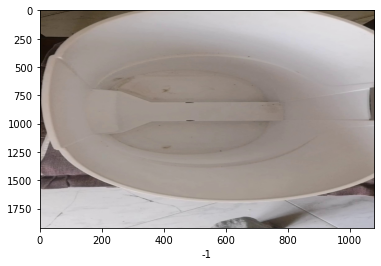

In [4]:
## visualizziamo un esempio:
print(dataset[0]['image'].shape, type(dataset[0]['image']))
plt.imshow(dataset[0]['image'].permute(1, 2, 0),aspect="auto")
plt.xlabel(dataset[0]['label'])
plt.show()

Prima di normalizzare e dividere il dataset ranomizzato in training e test utilizzando la funzion di sklearn calcoliamo media e dv std delle immagini originali senza rescaling

In [12]:
mean = dataset.mean
dev_std = dataset.dev_std

## calcoliamo media e dv standard prima di normalizzare e fare il resize dell'immagine

print("==== before calculated\nmean:", dataset.mean,"\ndev_std:", dataset.dev_std)
dataset._bef_normalize()

print("==== after calculated\nmean:", dataset.mean,"\ndev_std:", dataset.dev_std)
print(mean, dev_std)

# nota::: to understand the difference between the norm and none comment transform.normalize & torch.flatten
normaliz = transforms.Compose([ transforms.Resize(28), transforms.ToTensor(), transforms.Normalize(mean, dev_std), torch.flatten ])

# carico dataset normalizzato
dataset_norm = TrashbeanDataset('static/datasets/img', 'static/datasets/all_labels.txt', transform=normaliz )

==== before calculated
mean: [15.97790102 14.86453882 13.75977904] 
dev_std: [87.04510015 80.97970669 74.96385215]
==== after calculated
mean: [15.97790151 14.86453927 13.75977946] 
dev_std: [87.04510016 80.9797067  74.96385788]
[5.23563877e+08 4.87081223e+08 4.50880453e+08] [2.48278203e+11 2.14883136e+11 1.84142397e+11]


Controlliamo l'immagine alla prima posizione, applichiamo una permutazione randomica agli inidici e controlliamo nuovamente il corrispondente elemento:

In [31]:

print(type(dataset_norm[0]['image']), type(dataset_norm[0]['label']))

print(dataset_norm[0]['image'].shape)

plt.imshow((dataset_norm[0]['image']).permute(1, 2, 0),aspect="auto")
plt.xlabel(dataset_norm[0]['label'])
plt.show()

# permutazione randomica del dataset
dataset_norm.__random__() ## si deve fare dopo

print(dataset_norm[0]['image'].shape, type(dataset_norm[0]['image']))
plt.imshow(dataset_norm[0]['image'].permute(1, 2, 0),aspect="auto")
plt.xlabel(dataset_norm[0]['label'])
plt.show()

<class 'torch.Tensor'> <class 'int'>
torch.Size([4116])
torch.Size([4116])
<ipython-input-31-b31a5ba4df4a>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  datum_I_cc = torch.tensor(dataset_norm[0]['image'])


RuntimeError: number of dims don't match in permute

500
dimensione training: 350 
 dimensione test: 150


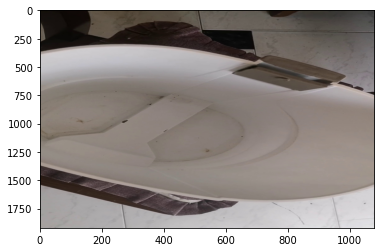

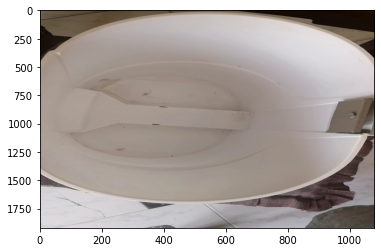

In [5]:
from sklearn.model_selection import train_test_split

print(dataset.__len__())
# print(dataset[0]['image'].shape, dataset[0]['label'])

training_data,test_data = train_test_split(dataset, test_size=150, train_size=350, random_state=None, shuffle=True, stratify=None)

Controlliamo che i dati siano splittati correttamente:

dimensione training: 350 
dimensione test: 150


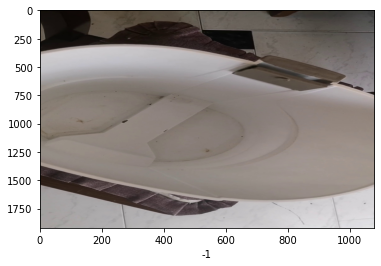

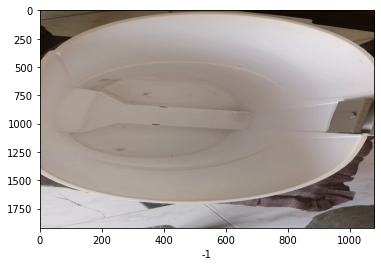

In [14]:
print("dimensione training:", training_data.__len__(),"\ndimensione test:", test_data.__len__())

plt.imshow(test_data[0]['image'].permute(1, 2, 0),aspect="auto")
plt.xlabel(test_data[0]['label'])
plt.show()

plt.imshow(training_data[0]['image'].permute(1, 2, 0),aspect="auto")
plt.xlabel(test_data[0]['label'])
plt.show()

## todo per continuare

Dobbiamo dividere il dataset in training e test (randomizzato)

calcoliamo media e dv standard prima di fare il resize dell'immagine (prima di fare il resize) e applicare la normalizzazione (come nel codice di sotto solo riscrivelo meglio e fare per trainin e test)

implementare il softmax con mlp

In [18]:
print("dimensione training:", training_data.__len__(),"\ndimensione test:", test_data.__len__())

print(type(training_data), type(training_data[0]['image']))

print(type(dataset))

dimensione training: 350 
dimensione test: 150
<class 'list'> <class 'torch.Tensor'>
<class '__main__.TrashbeanDataset'>
